In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import base64

tqdm.pandas()
from wekeypedia import WikipediaPage as Page

In [2]:
name = 'Elke Mackenzie'
dead_name = 'SXZhbg=='
page_name = 'Ivan_Mackenzie_Lamb'
co_date = None

In [3]:
def format_revid_index(revid, page):
    return f'<a href="https://fr.wikipedia.org/w/index.php?title={page}&diff=prev&oldid={revid}">{revid}</a>'

# qui sont personnes qui énoncent le deadname dans l'article ?

## article

In [4]:
page = Page(page_name, lang='fr')

In [5]:
revisions = (
    pd
    .DataFrame
    .from_records(page.get_revisions())
    .set_index('revid')
)

revisions

,parentid,user,userid,timestamp,size,sha1,contentformat,contentmodel,comment,*,anon
revid,,,,,,,,,,,
213844287,213844145,Cymbella,316223,2024-03-31T17:49:57Z,14621,3bfade8089890811e9b090bfaf7e3630ca08c5bb,text/x-wiki,wikitext,/* Collections et archives */ reformulation no...,{{voir homonymes|Mackenzie|Lamb}}\n{{Infobox B...,NaN
213844145,213842295,Cymbella,316223,2024-03-31T17:44:37Z,14629,d6fe03e932e2c2a061fc69724e1fdf75b8cfa225,text/x-wiki,wikitext,/* Identité de genre et dernières années */ re...,{{voir homonymes|Mackenzie|Lamb}}\n{{Infobox B...,NaN
213842295,213841635,Shev123,1144964,2024-03-31T16:42:01Z,14662,9440533d666f7053d36d17e78347bebbe187ab8e,text/x-wiki,wikitext,"retrait du sous-titre, modèle inapproprié pour...",{{voir homonymes|Mackenzie|Lamb}}\n{{Infobox B...,NaN
213841635,213841602,Cymbella,316223,2024-03-31T16:18:49Z,14692,69ce53815f2b67b9dda9e2a1f162387cd74d3c52,text/x-wiki,wikitext,+ sous-titre,{{sous-titre|Elke Mackenzie}}\n{{voir homonyme...,NaN
213841602,213839792,Cymbella,316223,2024-03-31T16:17:44Z,14662,9440533d666f7053d36d17e78347bebbe187ab8e,text/x-wiki,wikitext,formulation évitant de genrer,{{voir homonymes|Mackenzie|Lamb}}\n{{Infobox B...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
179466871,179466834,Cymbella,316223,2021-02-01T16:32:35Z,10596,1a78da4baf1b9b45045c61155d775a13c38aed53,text/x-wiki,wikitext,/* Carrière */ précision,{{Infobox Biographie 2\n|charte=botaniste}}\n'...,NaN
179466834,179466796,Cymbella,316223,2021-02-01T16:31:32Z,10585,4b1581edbadffb364b691ba2ced0e02fb4f0ac3a,text/x-wiki,wikitext,/* Carrière */ relecture,{{Infobox Biographie 2\n|charte=botaniste}}\n'...,NaN
179466796,179466692,Cymbella,316223,2021-02-01T16:30:33Z,10584,a01435f3a8e93409e8daf0352cc3af588a5a155a,text/x-wiki,wikitext,/* Introduction */ + liens int,{{Infobox Biographie 2\n|charte=botaniste}}\n'...,NaN


In [6]:
revisions.to_csv(f'../data/page-revisions/{page_name.lower()}.csv')

In [7]:
def decode(string):
    return base64.b64decode(string).decode("utf-8")

<Axes: xlabel='date'>

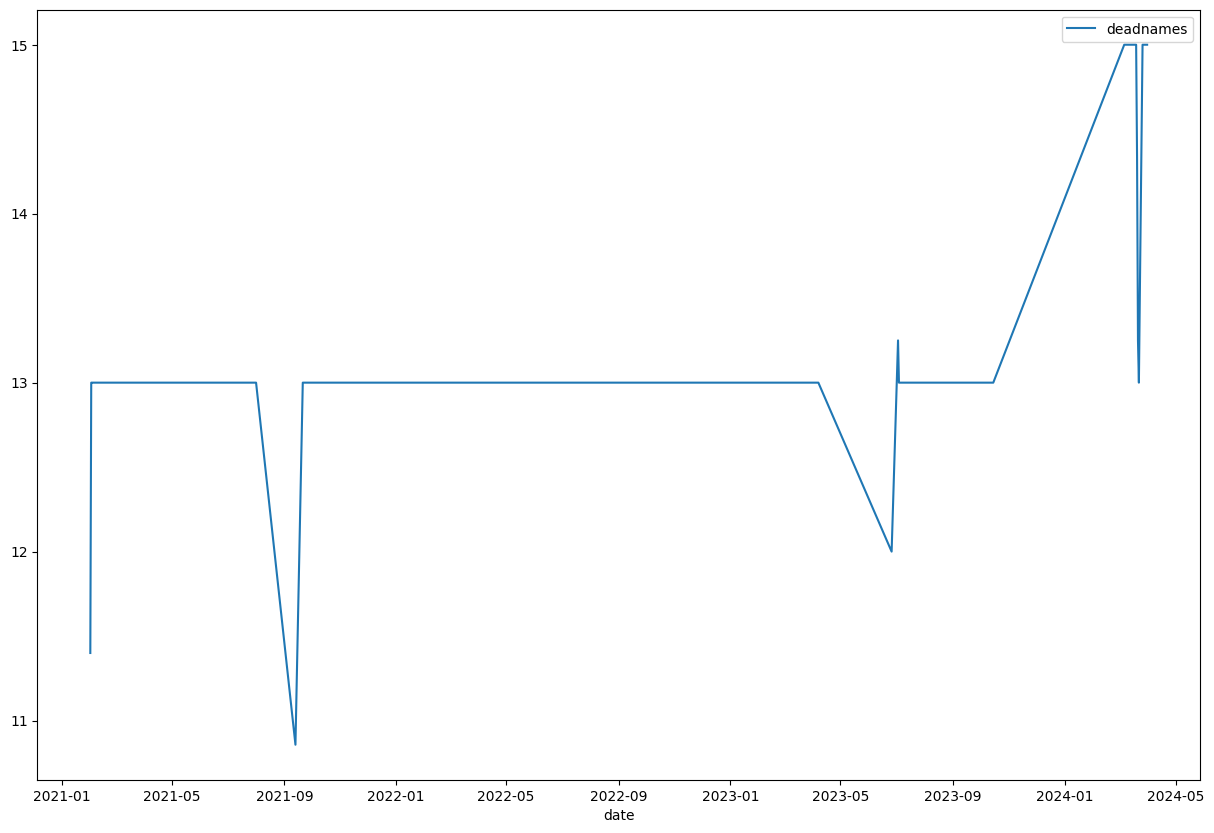

In [8]:
(
    revisions
    .assign(
        deadnames = lambda df: df['*'].apply(lambda x: str(x).lower().count(decode(dead_name).lower()))
    )
    #.reset_index()
    [['timestamp', 'deadnames']]
    .assign(
        date = lambda df: pd.to_datetime(df.timestamp).dt.date
    )
    .groupby('date')
    .agg({'deadnames': 'mean'})
    .plot
    .line(
        figsize=(15,10)
    )
)

In [9]:
def get_diff(revid):
    return page.get_diff(revid)

diffs = revisions.reset_index().revid.progress_apply(lambda x: page.extract_plusminus(get_diff(x))['added'] )

#diffs

100%|███████████████████████████████████████████| 80/80 [00:26<00:00,  3.01it/s]


### depuis le coming out

In [10]:
(
    revisions
    .assign(
        deadname_count = [ ' '.join(added).lower().count(decode(dead_name).lower()) for added in diffs ]
    )
    # on ne garde que les contributions après son coming out
    .pipe(lambda df: df.query(f'timestamp >= "{co_date}"') if co_date != None else df)
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

user
Cymbella                              14
Biologisteantique                      2
2A02:8440:5304:1188:0:1B:C326:2F01     1
Anne Daemon                            1
Cardabela48                            0
Criric                                 0
FR                                     0
La Grande Feutrelle                    0
Matpib                                 0
Pierrette13                            0
Name: deadname_count, dtype: int64

### depuis le début du sondage

In [11]:
(
    revisions
    .assign(
        deadname_count = [ ' '.join(added).lower().count(decode(dead_name).lower()) for added in diffs ]
    )
    # début du sondage
    .query('timestamp >= "2024-02-12"')
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

user
Cymbella       4
Anne Daemon    1
Shev123        0
Name: deadname_count, dtype: int64

In [12]:
(
    revisions
    .assign(
        deadname_count = [ ' '.join(added).lower().count(decode(dead_name).lower()) for added in diffs ]
    )
    # début du sondage
    .query('timestamp >= "2024-01-15"')
    .query('deadname_count > 0')
    [['user', 'deadname_count', 'timestamp']]
    .style
    .format_index(lambda x: format_revid_index(x, page_name))
)

,user,deadname_count,timestamp
revid,,,
213704822,Cymbella,2,2024-03-26T20:16:14Z
213513219,Anne Daemon,1,2024-03-20T14:40:41Z
213112486,Cymbella,2,2024-03-06T14:52:30Z


## Discussions

In [13]:
talk = Page(f'Discussion:{page_name}', lang='fr')

In [14]:
talk_revisions = (
    pd
    .DataFrame
    .from_records(talk.get_revisions_list())
    .assign(
        diff = lambda df: df.revid.progress_apply(lambda x: talk.get_diff(x)),
        deleted = lambda df: df['diff'].apply(lambda diff: talk.extract_plusminus(diff)['deleted']),
        added = lambda df: df['diff'].apply(lambda diff: talk.extract_plusminus(diff)['added']),
    )
    .set_index('revid')
)

#talk_revisions

100%|███████████████████████████████████████████| 94/94 [00:29<00:00,  3.17it/s]


In [15]:
talk_revisions.to_csv(f'../data/page-diffs/discussion:{page_name.lower()}.csv')

### depuis le coming out

In [16]:
(
    talk_revisions
    .assign(
        deadname_count = lambda df: df.added.apply(lambda x: ' '.join(x).lower().count(decode(dead_name).lower()))
    )
    # on ne garde que les contributions après son coming out
    #.query('timestamp >= "2013-08-22"')
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

user
Cymbella                                16
Sherwood6                                7
Enthalpist                               6
2A01:CB18:3A1:600:7D38:3E1:EB42:DB05     1
Le GreeKiwi                              1
Kvardek du                               0
Shev123                                  0
Léna                                     0
Lambig44                                 0
La Grande Feutrelle                      0
Name: deadname_count, dtype: int64

### depuis le début du sondage

In [17]:
(
    talk_revisions
    .assign(
        deadname_count = lambda df: df.added.apply(lambda x: ' '.join(x).lower().count(decode(dead_name).lower()))
    )
    # depuis le sondage
    .query('timestamp >= "2024-02-12"')
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

user
Cymbella                                  9
Enthalpist                                6
Sherwood6                                 6
2A01:CB18:3A1:600:7D38:3E1:EB42:DB05      1
Le GreeKiwi                               1
2A02:8440:A10A:6893:8C9A:7FF:FEBB:6102    0
2A04:8EC0:0:216:CE0B:3DD0:28C:416F        0
Anne Daemon                               0
Jeune Lutin                               0
Jugio                                     0
Name: deadname_count, dtype: int64

In [18]:
(
    talk_revisions
    .assign(
        deadname_count = lambda df: df.added.apply(lambda x: ' '.join(x).lower().count(decode(dead_name).lower()))
    )
    # depuis le sondage
    .query('timestamp >= "2024-02-12"')
    .query('deadname_count > 0')
    [['user', 'deadname_count', 'timestamp']]
    .style
    .format_index(lambda x : format_revid_index(x, f'Discussion:{page_name}'))
)

,user,deadname_count,timestamp
revid,,,
213843134,Cymbella,1,2024-03-31T17:10:53Z
213751051,2A01:CB18:3A1:600:7D38:3E1:EB42:DB05,1,2024-03-28T11:41:08Z
213747283,Enthalpist,2,2024-03-28T09:02:54Z
213733772,Enthalpist,3,2024-03-27T18:43:44Z
213732723,Sherwood6,1,2024-03-27T17:58:19Z
213731305,Enthalpist,1,2024-03-27T17:11:37Z
213729217,Cymbella,1,2024-03-27T16:01:44Z
213723362,Sherwood6,1,2024-03-27T12:43:39Z
213538736,Cymbella,1,2024-03-21T13:50:11Z


In [19]:
len(
    talk_revisions
    .assign(
        deadname_count = lambda df: df.added.apply(lambda x: ' '.join(x).lower().count(decode(dead_name).lower()))
    )
    # depuis le sondage
    .query('timestamp >= "2024-02-12"')
    .query('deadname_count > 0')
    [['user', 'deadname_count']]
)

18